In [2]:
import torch
import sklearn.datasets
from matplotlib import pyplot as plt
import numpy as np

In [32]:
X, Y = sklearn.datasets.make_blobs(
    n_samples=100,
    n_features=2,
    centers=2,
    random_state=1,
)

z = lambda w0, w1, b, x0, x1: w0*x0 + w1*x1 + b
y = lambda v: (1 / (1 + torch.exp(-v))).clamp(0.00001, 0.99999)
H = lambda y, yt: -1 * ((yt * torch.log(y)) + (1-yt)*torch.log(1-y))

In [107]:
def draw(title, params):
    w0, w1, b = params
    
    plt.figure()
    fig, ax = plt.subplots()
    fig.suptitle(title)
    ax.set_title("with contours")

    min_x0, min_x1 = X.min(0)
    max_x0, max_x1 = X.max(0)

    # # draw a line where the classification is 0.5
    # # z is defined by $z = w0x0 + w1x1 + b$.
    # # solving x1 for z = 0.5 we get $x1 = (0.5 - w0x0 - b)/w1$ 
    # line_domain = torch.tensor([min_x0, max_x0])
    # line_range = (0.5 - line_domain*w0 - b) / w1
    # plt.plot(line_domain, line_range)

    delta = .25
    x0 = np.arange(min_x0, max_x0, delta)
    x1 = np.arange(min_x1, max_x1, delta)
    x0, x1 = np.meshgrid(x0, x1)
    x0 = torch.tensor(x0)
    x1 = torch.tensor(x1)
    
    cs = plt.contour(
        x0, x1, y(z(w0, w1, b, x0, x1)),
        levels=3,
        cmap="Greys")

    ax.clabel(cs, inline=True, fontsize=14)

    # draw the classes data points
    plt.scatter(x=X[:,0], y=X[:,1], c=Y, cmap="Greys", edgecolor="black")

def calc_dC(params):
    w0, w1, b = params
    
    # For each sample, we need to calculate dH/dw0, dH/dw1 and dH/db
    dH = torch.empty(len(Y), 3)

    for i in range(len(Y)):
        x0, x1, yt = X[i, 0], X[i, 1], Y[i]
        y_model = y(z(w0, w1, b, x0, x1))

        dHdy = -1*(yt-y_model)/(y_model-y_model**2)
        dydz = (y_model) / (1 + y_model)**2
        dzdw0 = x0
        dzdw1 = x1
        dzdb = 1

        dH[i, :] = dHdy * dydz * torch.tensor([dzdw0, dzdw1, dzdb])

        if  dH[i,:].isnan().any():
            print("w0", w0)
            print("w1", w1)
            print("b", b)
            print("x0", x0)
            print("x1", x1)
            print("yt", yt)
            print("y_model", y_model)
            print("dHdy", dHdy)
            print("dydz", dydz)
            print("dzdw0", dzdw0)
            print("dzdw1", dzdw1)
            print("dzdb", dzdb)
            raise Exception(f"dH[{i}] is NAN: {dH[i,:]}")

    assert not torch.isnan(dH).any(), f"dH is NAN: {dH}"

    mean = dH.mean(0)
    # assert not torch.isnan(mean).any(), f"mean is NAN: {mean}"
    return mean

def compute_cost(p):
    w0, w1, b = p

    costs = torch.empty(len(Y), 1)
    for i in range(len(Y)):
        x0, x1, yt = X[i,0], X[i,1], Y[i]
        y_model = y(z(w0, w1, b, x0, x1))
        costs[i,0] = H(y_model, yt)

    return costs.mean(0).item()

Text(0.5, 1.0, 'epochs=20, alpha=0.1')

<Figure size 640x480 with 0 Axes>

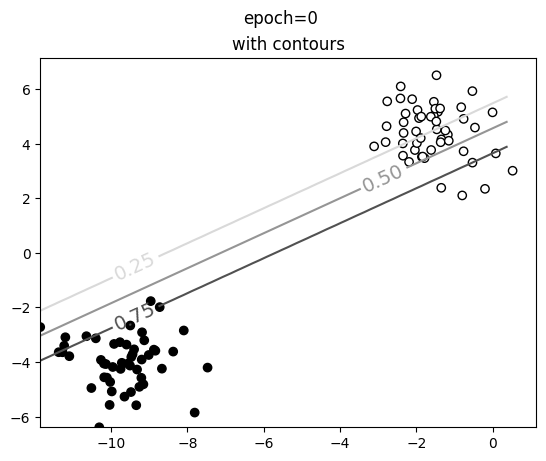

<Figure size 640x480 with 0 Axes>

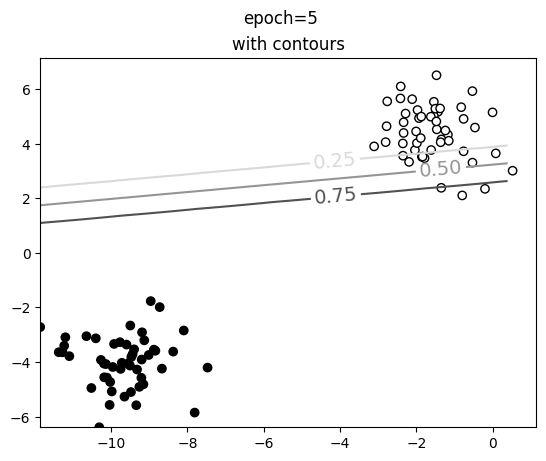

<Figure size 640x480 with 0 Axes>

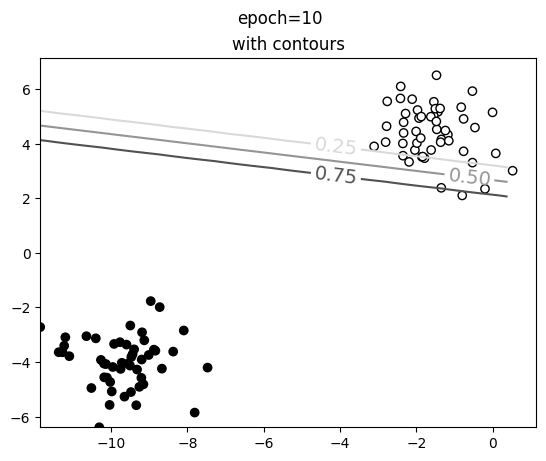

<Figure size 640x480 with 0 Axes>

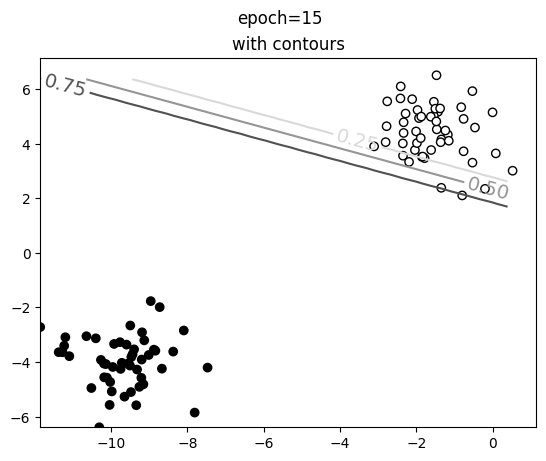

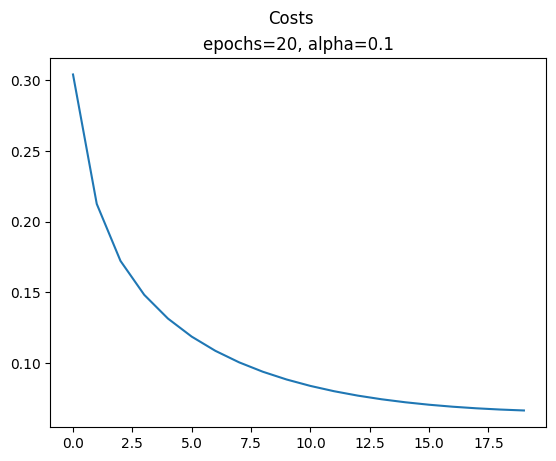

In [109]:
# initialization
p = torch.tensor(1), torch.tensor(-1), torch.tensor(5.5)
alpha = 0.1
epochs = 20

costs = torch.empty(epochs)
for epoch in range(epochs):
    step = alpha * calc_dC(p)
    
    # update parameters
    p = tuple((
        p[i] - step[i]
        for i
        in range(len(p))))

    costs[epoch] = compute_cost(p)

    if epoch % 5 == 0:
        draw(f"epoch={epoch}", p)

fig, ax = plt.subplots()
l2d = plt.plot(range(len(costs)), costs)
fig.suptitle("Costs")
ax.set_title(f"epochs={epochs}, alpha={alpha}")